In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json
/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json


In [2]:
# regular expression and string case
import re
import string

# Data reading
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

In [4]:
#Function to get a equal number of data from both classification
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

# Cummulation of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]


# Removing the stop word and tags
def remove_stopwords(data):
    data['review_ws'] = data['review_text'].apply(lambda x :' '.join([word for word in x.split() 
                                                                 if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

In [5]:
old_data = get_part_data(df_reviews, 110000)

In [6]:
# open new a feature as cleaned review text
data_ws = remove_stopwords(old_data)
data_ws['clean_review']= data_ws['review_ws'].apply(lambda cw : remove_tags(cw))
data_ws['clean_review'] = data_ws['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [7]:
embedded_words = {}
with open('../input/glove-embeddings/glove.6B.300d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff
        

# Funstion to convert the sentence to vectorts by using the Glove
def get_sentence_vectors(text):
    sentence_vector = np.zeros((300,))
    if len(text)==0:
        return sentence_vector
    for word_token in text:
        if word_token in embedded_words:
            sentence_vector += embedded_words[word_token]
    sentence_vector = sentence_vector/len(text)
    return sentence_vector

In [8]:
data_ws['new_data'] = data_ws['clean_review'].apply(get_sentence_vectors)

In [9]:
train_X = data_ws['new_data']
train_Y = data_ws['is_spoiler']

#train test split
tra_X, val_X, tra_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.3, random_state=1)
print('train_features: ', tra_X.shape)
print('validation_features: ', val_X.shape)
print('train_target: ', tra_Y.shape)
print('validation_target: ', val_Y.shape)

# label encoder used to tranform the labels
le = LabelEncoder()
tra_y = le.fit_transform(tra_Y)
val_y = le.fit_transform(val_Y)

# train and test split


train_features:  (154000,)
validation_features:  (66000,)
train_target:  (154000,)
validation_target:  (66000,)


## Random Forest Model

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4,n_jobs = -1, random_state=0)
clf.fit(tra_X.to_list(), tra_y)

RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=0)

In [17]:
train_pred = clf.predict(tra_X.to_list())
test_pred = clf.predict(val_X.to_list())

## Classification Report

In [18]:
from sklearn.metrics import classification_report
print(classification_report(tra_y,train_pred))
print(classification_report(val_y,test_pred))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56     77066
           1       0.58      0.69      0.63     76934

    accuracy                           0.60    154000
   macro avg       0.60      0.60      0.60    154000
weighted avg       0.60      0.60      0.60    154000

              precision    recall  f1-score   support

           0       0.62      0.51      0.55     32934
           1       0.58      0.69      0.63     33066

    accuracy                           0.60     66000
   macro avg       0.60      0.60      0.59     66000
weighted avg       0.60      0.60      0.59     66000



## Auc Plot

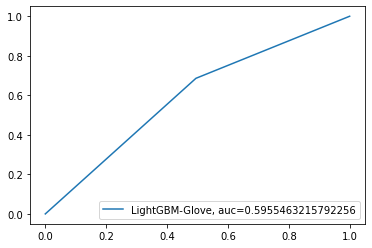

In [19]:
import sklearn.metrics as metrics
fpr, tpr, _ = metrics.roc_curve(val_y,  test_pred)
auc = metrics.roc_auc_score(val_y, test_pred)
plt.plot(fpr,tpr,label="LightGBM-Glove, auc="+str(auc))
plt.legend(loc=4)
plt.show()